In [1]:
import gym
from gym.spaces import Discrete
from gym.envs.registration import register
import numpy as np
import sys
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

Define environment for Boyan Chain

In [2]:
class BoyanChainEnv(gym.Env):

    def __init__(self):
        self.num_states = 13;
        self.action_space = Discrete(2);
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        action = action+1
        self.action = action
        self.prev_state = self.cur_state
        self.cur_state = self.prev_state-action
        if self.cur_state == 0:
            reward = -2
            done = True
        else:
            reward = -3
            done = False
        self.episode_total_reward = self.episode_total_reward+reward

        return {'cur_state':self.cur_state, 'prev_state':self.prev_state}, reward, done, {}


    def reset(self):
        self.cur_state = 12
        self.time = 0
        self.episode_total_reward = 0

    def render(self, mode='human'):
        outfile = sys.stdout
        inp = "time step: %d\n" % self.time
        outfile.write(inp)
        inp = "took action %d at state %d and arrive at state %d\n" %(self.action, self.prev_state, self.cur_state)
        outfile.write(inp)
        outfile.write("total reward received so far is %d\n\n" %self.episode_total_reward)

Register environment

In [3]:
register(
    id='BoyanChainEnv-v0',
    entry_point='gym.envs.algorithmic:BoyanChainEnv',
    max_episode_steps=200,
)
env = gym.make('BoyanChainEnv-v0')

Define the feature vectors for Boyan Chain

In [4]:
Phi = [np.array([0,0,0,0]), np.array([0,0,1/4,3/4]), np.array([0,0,1/2,1/2]), np.array([0,0,3/4,1/4]),
       np.array([0,0,1,0]), np.array([0,1/4,3/4,0]), np.array([0,1/2,1/2,0]), np.array([0,3/4,1/4,0]),
       np.array([0,1,0,0]), np.array([1/4,3/4,0,0]), np.array([1/2,1/2,0,0]), np.array([3/4,1/4,0,0]),
       np.array([1,0,0,0])]

Run offline LSTD($\lambda$) on Boyan Chain

In [5]:
def offline_LSTD_lambda_Boyan(lambda_lstd):
    num_states = len(Phi)
    num_features = len(Phi[0])
    num_eps = 20
    A = np.zeros((num_features, num_features))
    b = np.zeros((num_features, 1))
    beta_opt =np.array([-24,-16,-8,0]).reshape(num_features,1)
    result = np.zeros((num_eps))

    for i_episode in range(num_eps):
        env.reset()
        cur_state = num_states - 1
        z = Phi[cur_state].reshape((num_features, 1))
        for t in range(100):
            if cur_state == 1:
                action = 0
            else:
                action = env.action_space.sample() #we can take a sample here because an action is chosen with prob 50%
            observation, reward, done, info = env.step(action)
            cur_state = observation['cur_state']
            prev_state = observation['prev_state']
            A = A + z@(Phi[prev_state]-Phi[cur_state]).reshape((1,num_features))
            b = b + reward*z
            z = lambda_lstd*z + Phi[cur_state].reshape((num_features, 1))
            #env.render()
            if done:
                #print("Episode finished after {} timesteps".format(t+1))
                break
        beta = np.linalg.solve(A,b)
        result[i_episode] = np.linalg.norm(beta-beta_opt,ord=np.inf)
    return beta, result

In [6]:
offline_LSTD_lambda_Boyan(0.4)

(array([[-23.01793177],
        [-14.90567642],
        [ -7.51577873],
        [  0.24691506]]),
 array([ 4.29954461,  4.10353006,  2.39934431,  2.45144097,  2.02363196,
         1.50070896,  1.83446131,  2.14729416,  2.04166333,  1.57158964,
         1.50659713,  1.69418628,  1.58071239,  1.43732772,  1.40779372,
         1.22709937,  1.2595056 ,  1.28942755,  1.10308457,  1.09432358]))

First output in the above result is learned beta and it is very similar to the ground truth.

In the recursive formulation of LSTD-$\lambda$, we use Sherman-Morrison formula to approximate inverse of $A$. This update could cause numerical instabilities because the division in the formula will cause rounding errors. Now we show the implementation of recursive LSTD($\lambda$) on Boyan chain

In [7]:
def recursive_LSTD_lambda_Boyan(lambda_lstd):
    num_states = len(Phi)
    num_features = len(Phi[0])
    num_eps = 20
    gamma = 1
    A = (1/0.001) * np.identity(num_features)
    b = np.zeros((num_features, 1))
    beta_opt =np.array([-24,-16,-8,0]).reshape(num_features,1)
    result = np.zeros((num_eps))

    for i_episode in range(num_eps):
        env.reset()
        cur_state = num_states - 1
        z = Phi[cur_state].reshape((num_features, 1))
        for t in range(100):
            if cur_state == 1:
                action = 0
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            cur_state = observation['cur_state']
            prev_state = observation['prev_state']
            phi_x_cur = Phi[cur_state].reshape((num_features,1))
            phi_x_prev = Phi[prev_state].reshape((num_features,1))
            v = np.transpose(A) @ (phi_x_prev - gamma*phi_x_cur)
            A = A - (A@z)@v.reshape(1,num_features)/(1+v.reshape(1,num_features)@z)
            b = b + reward*z
            z = lambda_lstd*z + phi_x_cur
            #env.render()
            if done:
                #print("Episode finished after {} timesteps".format(t+1))
                break
        beta = A@b
        result[i_episode] = np.linalg.norm(beta-beta_opt,ord=np.inf)
    return beta, result

In [8]:
recursive_LSTD_lambda_Boyan(0.4)

(array([[-24.01776769],
        [-16.21162303],
        [ -7.91609973],
        [  0.22149948]]),
 array([ 2.45127888,  1.00245769,  1.1387267 ,  0.66205689,  0.79894933,
         1.05611376,  1.07762308,  0.88748174,  1.23017343,  0.98006625,
         0.81539343,  0.67694838,  0.65474005,  0.4503371 ,  0.54171912,
         0.37058533,  0.4132864 ,  0.52737599,  0.31352297,  0.22149948]))

This result is also pretty close to the ground truth, so this is nice. 

Now we examine the effect of $\lambda$ on learning rate by using the offline approach

Text(0,0.5,'error between beta and beta*')

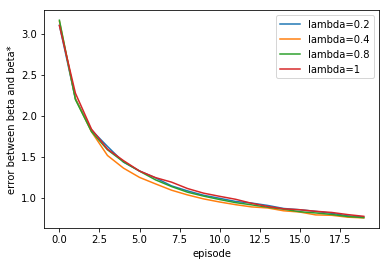

In [9]:
lambdas = [0.2, 0.4, 0.8, 1]
plt.figure()
for i in range(len(lambdas)):
    #try each lambda 100 times and average the results
    result = 0
    for j in range(500):
        beta, temp_result = offline_LSTD_lambda_Boyan(lambdas[i])
        result = result + temp_result
    result = result/500
    line, = plt.plot(result)
    line.set_label('lambda='+str(lambdas[i]))
plt.legend()
plt.xlabel('episode')
plt.ylabel('error between beta and beta*')

We can also try different lambda on the recursive approach

Text(0,0.5,'error between beta and beta*')

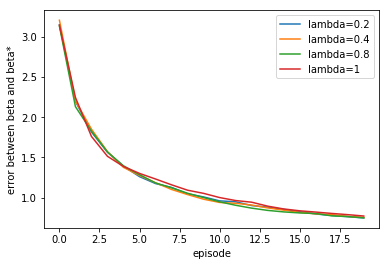

In [0]:
lambdas = [0.2, 0.4, 0.8, 1]
plt.figure()
for i in range(len(lambdas)):
    #try each lambda 100 times and average the results
    result = 0
    for j in range(500):
        beta, temp_result = recursive_LSTD_lambda_Boyan(lambdas[i])
        result = result + temp_result
    result = result/500
    line, = plt.plot(result)
    line.set_label('lambda='+str(lambdas[i]))
plt.legend()
plt.xlabel('episode')
plt.ylabel('error between beta and beta*')

Define the environment for five-states domain

In [10]:
class FiveStateEnv(gym.Env):

    Transistion = [np.array([0.42, 0.13, 0.14, 0.03, 0.28]),
                   np.array([0.25, 0.09, 0.16, 0.35, 0.15]),
                   np.array([0.08, 0.2, 0.33, 0.17, 0.22]),
                   np.array([0.36, 0.05, 0, 0.52, 0.07]),
                   np.array([0.17, 0.24, 0.19, 0.18, 0.22])]

    Reward = [[104.66, 29.69, 82.36, 37.49, 68.82],
              [75.86, 29.24, 100.37, 0.31, 35.99],
              [57.68, 65.66, 56.95, 100.44, 47.63],
              [96.23, 14.01, 0.88, 89.77, 66.77],
              [70.35, 23.69, 73.41, 70.70, 85.41]]

    reward_scaling_factor = 1

    def __init__(self):
        self.num_states = 5;
        self.reset()

    def step(self, action):
        self.prev_state = self.cur_state
        self.cur_state = np.random.choice(self.num_states, p=FiveStateEnv.Transistion[self.prev_state])
        reward = self.reward_scaling_factor*FiveStateEnv.Reward[self.prev_state][self.cur_state]
        done = False
        self.time = self.time+1
        self.episode_total_reward = self.episode_total_reward+reward

        return {'cur_state':self.cur_state, 'prev_state':self.prev_state}, reward, done, {}


    def reset(self):
        self.cur_state = np.random.randint(5)
        self.time = 0
        self.episode_total_reward = 0
        return self.cur_state

    def render(self, mode='human'):
        outfile = sys.stdout
        inp = "time step: %d\n" % self.time
        outfile.write(inp)
        inp = "at state %d and arrive at state %d\n" %(self.prev_state, self.cur_state)
        outfile.write(inp)
        outfile.write("total reward received so far is %d\n\n" %self.episode_total_reward)

In [11]:
register(
    id='FiveStateEnv-v0',
    entry_point='gym.envs.algorithmic:FiveStateEnv',
    max_episode_steps=500,
)
env = gym.make('FiveStateEnv-v0')

Define feature vectors for five-states environment

In [12]:
Phi = [np.array([74.29, 34.61, 73.48, 53.29, 7.79]),
       np.array([61.6, 48.07, 34.68, 36.19, 82.02]),
       np.array([97, 4.88, 8.51, 87.89, 5.17]),
       np.array([41.1, 40.13, 64.63, 92.67, 31.09]),
       np.array([7.76, 79.82, 43.78, 8.56, 61.11])]

Now we show the implementation of offline LSTD($\lambda$) and recursive LSTD($\lambda$) on five-states domain

In [13]:
def offline_LSTD_lambda_FiveStates(lambda_lstd):
    num_states = len(Phi)
    num_features = len(Phi[0])
    num_episode = 50
    num_steps = 40
    gamma = 0.9
    A = np.zeros((num_features, num_features))
    b = np.zeros((num_features, 1))
    theta_opt =np.array([3.916,9.374,-0.933,3.203,-1.093]).reshape(num_features,1)
    result = np.zeros((num_episode))

    cur_state = env.reset()
    z = Phi[cur_state].reshape((num_features, 1))
    for i in range(num_episode):
        for t in range(num_steps):
            observation, reward, done, info = env.step(0)
            cur_state = observation['cur_state']
            prev_state = observation['prev_state']
            A = A + z@(Phi[prev_state]-gamma*Phi[cur_state]).reshape((1,num_features))
            b = b + reward*z
            z = lambda_lstd*z + Phi[cur_state].reshape((num_features, 1))
            #env.render()
        theta = np.linalg.solve(A, b)
        result[i] = np.linalg.norm(theta - theta_opt, ord=2)
    return theta, result

In [30]:
def recursive_LSTD_lambda_FiveStates(lambda_lstd):
    num_states = len(Phi)
    num_features = len(Phi[0])
    num_steps = 40
    num_episode = 50
    lambda_lstd = 0.2
    gamma = 0.9
    A = (1/0.01) * np.identity(num_features)
    b = np.zeros((num_features, 1))
    theta_opt =np.array([3.916,9.374,-0.933,3.203,-1.093]).reshape(num_features,1)
    result = np.zeros((num_episode))

    cur_state = env.reset()
    z = Phi[cur_state].reshape((num_features, 1))
    for i in range(num_episode):
        for t in range(num_steps):
            observation, reward, done, info = env.step(0)
            cur_state = observation['cur_state']
            prev_state = observation['prev_state']
            phi_x_cur = Phi[cur_state].reshape((num_features,1))
            phi_x_prev = Phi[prev_state].reshape((num_features,1))
            v = np.transpose(A) @ (phi_x_prev - gamma*phi_x_cur)
            A = A - (A@z)@v.reshape(1,num_features)/(1+v.reshape(1,num_features)@z)
            b = b + reward*z
            z = lambda_lstd*z + phi_x_cur
            # env.render()
        theta = A @ b
        result[i] = np.linalg.norm(theta-theta_opt,ord=np.inf)
    return theta, result

In [21]:
offline_LSTD_lambda_FiveStates(0.8)

(array([[ 3.97655406],
        [ 9.36317086],
        [-0.97893084],
        [ 3.09697991],
        [-1.14169196]]),
 array([ 0.91465795,  0.83081741,  0.4544102 ,  0.26461785,  0.54549723,
         0.63988474,  0.32115639,  0.45584682,  0.33870381,  0.36574055,
         0.20207951,  0.14541084,  0.16330116,  0.19648577,  0.15928086,
         0.15254133,  0.17104877,  0.16685842,  0.292905  ,  0.2883845 ,
         0.3149235 ,  0.34799652,  0.31365789,  0.32930445,  0.3280576 ,
         0.32349829,  0.2224018 ,  0.24961128,  0.25384661,  0.20479017,
         0.17883755,  0.14340105,  0.14054014,  0.14818381,  0.19420863,
         0.13830519,  0.13658083,  0.1499897 ,  0.14406384,  0.15532935,
         0.15918105,  0.15203019,  0.16182838,  0.18032114,  0.18159612,
         0.1651517 ,  0.16658999,  0.14392788,  0.14101436,  0.13965985]))

In [31]:
recursive_LSTD_lambda_FiveStates(0.8)

(array([[ 3.9198799 ],
        [ 9.29011668],
        [-0.82949762],
        [ 3.15848529],
        [-1.11608482]]),
 array([ 0.65386691,  0.94389761,  0.39623108,  0.3412586 ,  0.27232294,
         0.23423208,  0.12111416,  0.19813494,  0.21907942,  0.15445104,
         0.13785565,  0.22916847,  0.14036406,  0.11893376,  0.11246858,
         0.13467229,  0.11038773,  0.08339512,  0.11270285,  0.11929218,
         0.11895691,  0.11697538,  0.11701135,  0.10309771,  0.10231864,
         0.09144201,  0.10111955,  0.10180911,  0.10368983,  0.06829372,
         0.08258935,  0.08932622,  0.10230291,  0.10604259,  0.10766508,
         0.08968948,  0.0784992 ,  0.0808809 ,  0.08889224,  0.08411916,
         0.08271687,  0.08564161,  0.0987365 ,  0.08586934,  0.08317422,
         0.08694042,  0.09121044,  0.09314635,  0.09345595,  0.10350238]))

Text(0,0.5,'error between theta and theta*')

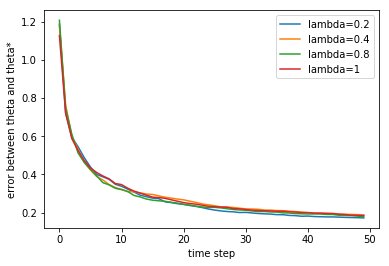

In [29]:
lambdas = [0.2, 0.4, 0.8, 1]
plt.figure()
for i in range(len(lambdas)):
    #try each lambda 200 times and average the results
    result = 0
    for j in range(200):
        theta,temp_result = recursive_LSTD_lambda_FiveStates(lambdas[i])
        result = result + temp_result
    result = result/200
    line, = plt.plot(result)
    line.set_label('lambda='+str(lambdas[i]))
plt.legend()
plt.xlabel('time step')
plt.ylabel('error between theta and theta*')

Text(0,0.5,'error between theta and theta*')

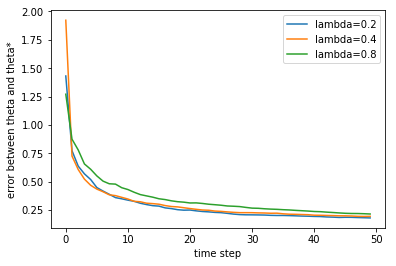

In [33]:
lambdas = [0.2, 0.4, 0.8]
plt.figure()
for i in range(len(lambdas)):
    #try each lambda 200 times and average the results
    result = 0
    for j in range(200):
        theta, temp_result = offline_LSTD_lambda_FiveStates(lambdas[i])
        result = result + temp_result
    result = result/200
    line, = plt.plot(result)
    line.set_label('lambda='+str(lambdas[i]))
plt.legend()
plt.xlabel('time step')
plt.ylabel('error between theta and theta*')

## Part 3.1: Equivalence of LSTD(1) and linear regression verification - Boyan Chain

To compute A and b with linear regression, we used the fomula provided under Appendix (P244) of Boyan's paper.

In [9]:
Phi = [np.array([0,0,0,0]), np.array([0,0,1/4,3/4]), np.array([0,0,1/2,1/2]), np.array([0,0,3/4,1/4]),
       np.array([0,0,1,0]), np.array([0,1/4,3/4,0]), np.array([0,1/2,1/2,0]), np.array([0,3/4,1/4,0]),
       np.array([0,1,0,0]), np.array([1/4,3/4,0,0]), np.array([1/2,1/2,0,0]), np.array([3/4,1/4,0,0]),
       np.array([1,0,0,0])]

num_states = len(Phi)
num_features = len(Phi[0])
A = np.zeros((num_features, num_features))
b = np.zeros((num_features, 1))
A_LSTD = np.zeros((num_features, num_features))
b_LSTD = np.zeros((num_features, 1))
lambda_lstd = 1.0#0.4

for i_episode in range(50):
    env.reset()
    traj = []
    rewards = []
    cur_state = num_states - 1
    z_LSTD = Phi[cur_state].reshape((num_features, 1))

    for t in range(100):
        if cur_state == 1:
            action = 0
        else:
            action = env.action_space.sample() #we can take a sample here because an action is chosen with prob 50%
        observation, reward, done, info = env.step(action)
        cur_state = observation['cur_state']
        prev_state = observation['prev_state']
        traj.append(prev_state)
        rewards.append(reward)
        A_LSTD = A_LSTD + z_LSTD@(Phi[prev_state]-Phi[cur_state]).reshape((1,num_features))
        b_LSTD = b_LSTD + reward*z_LSTD
        z_LSTD = lambda_lstd*z_LSTD + Phi[cur_state].reshape((num_features, 1))
        if done:
            break
    
    beta_LSTD = np.linalg.solve(A_LSTD,b_LSTD)
    
    for idx, x in enumerate(traj):
        y_x = sum(rewards[idx:])
        temp = Phi[x].reshape((num_features, 1))
        b = b + temp*y_x
        A = A + temp @ np.transpose(temp)
    beta = np.linalg.solve(A,b)

print("\nEquivalence of LSTD(1) and linear regression verification for Boyan env:")

print("beta_LSTD:\n{}".format(beta_LSTD))
print("beta_LR:\n{}".format(beta))

print("A_LSTD:\n{}".format(A_LSTD))
print("A_LR:\n{}".format(A))

print("b_LSTD:\n{}".format(b_LSTD))
print("b_LR:\n{}".format(b))



Equivalence of LSTD(1) and linear regression verification for Boyan env:
beta_LSTD:
[[-23.34141129]
 [-15.39777963]
 [ -7.29149346]
 [  0.12872651]]
beta_LR:
[[-23.34141129]
 [-15.39777963]
 [ -7.29149346]
 [  0.12872651]]
A_LSTD:
[[ 74.375  19.125   0.      0.   ]
 [ 19.125  92.375  20.5     0.   ]
 [  0.     20.5    90.     20.5  ]
 [  0.      0.     20.5    27.   ]]
A_LR:
[[ 74.375  19.125   0.      0.   ]
 [ 19.125  92.375  20.5     0.   ]
 [  0.     20.5    90.     20.5  ]
 [  0.      0.     20.5    27.   ]]
b_LSTD:
[[-2030.5 ]
 [-2018.25]
 [ -969.25]
 [ -146.  ]]
b_LR:
[[-2030.5 ]
 [-2018.25]
 [ -969.25]
 [ -146.  ]]


## Part 3.2: Equivalence of LSTD(1) and linear regression verification - Five State
simple modification made on the linear regression fomula from the Boyan's paper to accommodate five state convergence requirement by introducing gamma.
The modified linear regression fomula used can be derived with the following:

\begin{align}
\mathbf{A} &= \sum_{i=0}^L \mathbf{z}_{t}(\phi_{i}-\gamma\phi_{i+1})^T \notag\\
&= \sum_{i=0}^L(\sum_{j=0}^i\phi_{j})(\phi_{i}-\gamma\phi_{i+1})^T \notag\\
&= \sum_{i=0}^L\sum_{j=0}^i\phi_{j}\phi_{i}^T - \gamma\sum_{i=0}^L\sum_{j=0}^i\phi_{j}\phi_{i+1}^T \notag\\
&=(\phi_{0}\phi_{0}^T + \sum_{i=1}^L\sum_{j=0}^i\phi_{j}\phi_{i}^T) - \gamma(\sum_{k=1}^{L+1}\sum_{j=0}^{k-1})\phi_{j}\phi_{k}^T) \notag\\
&=\phi_{0}\phi_{0}^T + \sum_{i=1}^L\sum_{j=0}^i\phi_{j}\phi_{i}^T - \gamma\sum_{k=1}^{L}\sum_{j=0}^{k-1}\phi_{j}\phi_{k}^T) \notag\\
&=\phi_{0}\phi_{0}^T + \sum_{i=1}^L(\sum_{j=0}^i\phi_{j}\phi_{i}^T) - \gamma\sum_{j=0}^{i-1}\phi_{j}\phi_{i}^T) \notag\\
&=\phi_{0}\phi_{0}^T + \sum_{i=1}^L(\sum_{j=0}^{i-1}\phi_{j}\phi_{i}^T + \phi_{i}\phi_{i}^T - \gamma\sum_{j=0}^{i-1}\phi_{j}\phi_{i}^T) \notag\\
&=\phi_{0}\phi_{0}^T + \sum_{i=1}^L[(1-\gamma)\sum_{j=0}^{i-1}\phi_{j}\phi_{i}^T + \phi_{i}\phi_{i}^T] \notag
\end{align}

In [12]:
Phi = [np.array([74.29, 34.61, 73.48, 53.29, 7.79]),
       np.array([61.6, 48.07, 34.68, 36.19, 82.02]),
       np.array([97, 4.88, 8.51, 87.89, 5.17]),
       np.array([41.1, 40.13, 64.63, 92.67, 31.09]),
       np.array([7.76, 79.82, 43.78, 8.56, 61.11])]

num_states = len(Phi)
num_features = len(Phi[0])
lambda_lstd = 1.0  # 0.4
A = np.zeros((num_features, num_features))
b = np.zeros((num_features, 1))
gamma = 0.9
A_LSTD = np.zeros((num_features, num_features))
b_LSTD = np.zeros((num_features, 1))

for i_episode in range(1):
    cur_state = env.reset()
    traj = []
    rewards = []
    z = Phi[cur_state].reshape((num_features, 1))
    for t in range(10000):
        observation, reward, done, info = env.step(0)
        cur_state = observation['cur_state']
        prev_state = observation['prev_state']
        traj.append(prev_state)
        rewards.append(reward)
        A_LSTD = A_LSTD + z @ (Phi[prev_state] - gamma * Phi[cur_state]).reshape((1, num_features))
        b_LSTD = b_LSTD + reward * z
        z = lambda_lstd * z + Phi[cur_state].reshape((num_features, 1))
        # env.render()

    start = traj[0]
    temp = Phi[start].reshape((num_features, 1))
    A = A + temp @ np.transpose(temp)
    for idx_i, x in enumerate(traj):
        y_x = sum(rewards[idx_i:])
        temp_i = Phi[x].reshape((num_features, 1))
        b = b + temp_i * y_x
        if idx_i != 0:
            subtotal = 0
            for idx_j in range(idx_i - 1):
                sta = traj[idx_j]
                temp_j = Phi[sta].reshape((num_features, 1))
                subtotal = subtotal + temp_j * np.transpose(temp_i)
            subtotal = subtotal * (1 - gamma)
            subtotal = subtotal + temp_i @ np.transpose(temp_i)
            A = A + subtotal

beta_LSTD = np.linalg.solve(A_LSTD, b_LSTD)
beta = np.linalg.solve(A, b)

print("\nEquivalence of LSTD(1) and linear regression verification for FIVE STATE env:")

print("beta_LSTD:\n{}".format(beta_LSTD))
print("beta_LR:\n{}".format(beta))

print("A_LSTD:\n{}".format(A_LSTD))
print("A_LR:\n{}".format(A))

print("b_LSTD:\n{}".format(b_LSTD))
print("b_LR:\n{}".format(b))




Equivalence of LSTD(1) and linear regression verification for FIVE STATE env:
beta_LSTD:
[[ 3.81929948]
 [ 8.44180065]
 [-0.91298288]
 [ 3.55099366]
 [-0.46503439]]
beta_LR:
[[ 3.82388096]
 [ 8.19625009]
 [-0.85120155]
 [ 3.67615387]
 [-0.50084775]]
A_LSTD:
[[  1.54163170e+10   1.18653729e+10   1.42651346e+10   1.56577443e+10
    9.40479610e+09]
 [  1.14769542e+10   8.85366685e+09   1.06333603e+10   1.16588560e+10
    7.01881381e+09]
 [  1.40602293e+10   1.08360884e+10   1.30246111e+10   1.42840302e+10
    8.58704659e+09]
 [  1.56819170e+10   1.20741319e+10   1.45164342e+10   1.59356413e+10
    9.56942912e+09]
 [  9.03043230e+09   6.96778878e+09   8.36528954e+09   9.17353497e+09
    5.52748549e+09]]
A_LR:
[[  1.54337190e+10   1.18831020e+10   1.42946512e+10   1.57009496e+10
    9.41851012e+09]
 [  1.14902085e+10   8.86706600e+09   1.06556571e+10   1.16915786e+10
    7.02915461e+09]
 [  1.40763071e+10   1.08523283e+10   1.30515484e+10   1.43237795e+10
    8.59968345e+09]
 [  1.56996756

**As shown in the output, the A and b values from LSTD(1) and linear regression verification match for both cases.**